# Эффект изменения направления движения

In [1]:
#-ПОДКЛЮЧЕНИЕ-МОДУЛЕЙ-И-БИБЛИОТЕК-
%matplotlib notebook

import numpy              as np
import scipy
import matplotlib.pyplot  as plt
import glob
import moviepy.editor     as mpy

from scipy                import sparse
from scipy.sparse         import linalg
from numpy                import pi, sin, cos, ma
from pylab                import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib           import cm
from matplotlib.ticker    import LinearLocator, FormatStrFormatter
from matplotlib           import animation

In [27]:
#-ФУНКЦИЯ-СЧЕТА-ОДНОМЕРНОГО-УРАВНЕНИЯ-ПЕРЕНОСА-С-ВИРТУАЛЬНЫМИ-ТОЧКАМИ-
#------входные-аргументы------
# * sheme_name - схема для счета ('RK4+left', 'RK4+center2', 'RK4+center4', 'Euler+left')
# * x_max - отрезок пространства, на котором строится схема
# * t_max - отрезок времени, на котором строится схема
# * x_count - число отрезков разбиения
# * t_count - число слоев по времени
# * u - постоянная скорость (параметр задачи)
# * SC_in = start condition
# * BC1_in = boundary condition right

def OneDimensionalTransportSchemes(scheme_name, x_max, t_max, count_x, count_t, u, SC_in, BC1_in):
    
    
#--------------------EULER+LEFT--------------------
    if (scheme_name == 'Euler+left'):
        #-ИНИЦИАЛИЗАЦИЯ-СЕТКИ-И-ПАРАМЕТРОВ-ЗАДАЧИ-
        h      = (x_max)/count_x
        tau    = (t_max)/count_t
        x     = np.linspace(0,x_max+2*h,count_x+2)  #Сетки
        t     = np.linspace(0,t_max,count_t)
        PHI   = np.zeros((t.size,x.size))
        
        print("Число Куранта:")
        print(u*tau/h)
        
        #-ГРАНИЧНЫЕ-И-НАЧАЛЬНЫЕ-УСЛОВИЯ-
        SC  = zeros(x.size)
        SC[1:SC.size-1]  = SC_in

        SC[0]         = SC[SC.size-2]
        SC[SC.size-1] = SC[1]
        PHI[0,:]      = SC

        PHI[:,1] = BC1_in
        #-ОПЕРАТОР-ПРОСТРАСНТВЕННОГО-ДИФФЕРЕНЦИРОВАНИЯ-ДЛЯ-ЛЕВОЙ-НАПРАВЛЕННОЙ-РАЗНОСТИ-
        #(+)Переодическое продолжение решения

        def SpaceDiff_Euler_left(f,u,h):
            A     = np.zeros(f.size)+1
            B     = np.zeros(f.size)-1
            data  = np.array([u/h*B, u/h*A])
            diags = np.array([-1, 0])
            D     = sparse.spdiags(data, diags, f.size, f.size).toarray()
            D[0,f.size-1] =    u/(h) #Внесение переодичности методом виртуальных точек
            D[0,f.size-1] =   -u/(h) #Внесение переодичности методом виртуальных точек
            return D@f
        
        #-ВЫЧИСЛЕНИЯ-
        for j in range(t.size-1):
            PHI[j+1,:] = PHI[j,:] - tau*SpaceDiff_Euler_left(PHI[j,:],u,h)
        
        return [x[1:x.size-1], t, PHI[:,1:x.size-1]]
        
        
        
#--------------------RK4+LEFT--------------------
    elif (scheme_name == 'RK4+left'):
        #-ИНИЦИАЛИЗАЦИЯ-СЕТКИ-И-ПАРАМЕТРОВ-ЗАДАЧИ-
        h      = (x_max)/count_x
        tau    = (t_max)/count_t
        x     = np.linspace(0,x_max+2*h,count_x+2)  #Сетки
        t     = np.linspace(0,t_max,count_t)
        PHI   = np.zeros((t.size,x.size))
        
        #-ГРАНИЧНЫЕ-И-НАЧАЛЬНЫЕ-УСЛОВИЯ-
        SC  = zeros(x.size)
        SC[1:SC.size-1]  = SC_in

        SC[0]         = SC[SC.size-2]
        SC[SC.size-1] = SC[1]
        PHI[0,:]      = SC

        PHI[:,1] = BC1_in
        
        #-РЕАЛИЗАЦИЯ-РК4-
        def F(PHI):
            result = np.zeros(PHI.size)
            for i in range(1,PHI.size-1):
                result[i] = u*(PHI[i-1]-PHI[i])/(2*h)
            result[0] = result[PHI.size-2]
            result[PHI.size-1] = result[1]
            return result

        def w1(PHI):
            return F(PHI)

        def w2(PHI):
            return F(PHI+tau/2*w1(PHI))

        def w3(PHI):
            return F(PHI+tau/2*w2(PHI))

        def w4(PHI):
            return F(PHI+tau*w3(PHI))
        
        #-ВЫЧИСЛЕНИЯ-
        for j in range(t.size-1):
            PHI[j+1,:] = PHI[j,:] + tau/6*(w1(PHI[j,:])+2*w2(PHI[j,:])+2*w3(PHI[j,:])+w4(PHI[j,:]))
        
        return [x[1:x.size-1], t, PHI[:,1:x.size-1]]
    
    
    
#--------------------RK4+CENTER2--------------------
    elif (scheme_name == 'RK4+center2'):
        #-ИНИЦИАЛИЗАЦИЯ-СЕТКИ-И-ПАРАМЕТРОВ-ЗАДАЧИ-
        h      = (x_max)/count_x
        tau    = (t_max)/count_t
        x     = np.linspace(0,x_max+2*h,count_x+2)  #Сетки
        t     = np.linspace(0,t_max,count_t)
        PHI   = np.zeros((t.size,x.size))
        
        #-ГРАНИЧНЫЕ-И-НАЧАЛЬНЫЕ-УСЛОВИЯ-
        SC  = zeros(x.size)
        SC[1:SC.size-1]  = SC_in

        SC[0]         = SC[SC.size-2]
        SC[SC.size-1] = SC[1]
        PHI[0,:]      = SC

        PHI[:,1] = BC1_in
        
        #-РК4+ЦЕНТРАЛЬНАЯ-РАЗНОСТЬ-

        def F(PHI):
            result = np.zeros(PHI.size)
            for i in range(1,PHI.size-1):
                result[i] = u*(PHI[i-1]-PHI[i+1])/(2*h)
            result[0] = result[PHI.size-2]
            result[PHI.size-1] = result[1]
            return result

        def w1(PHI):
            return F(PHI)

        def w2(PHI):
            return F(PHI+tau/2*w1(PHI))

        def w3(PHI):
            return F(PHI+tau/2*w2(PHI))

        def w4(PHI):
            return F(PHI+tau*w3(PHI))
        
        #-ВЫЧИСЛЕНИЯ-
        for j in range(t.size-1):
            PHI[j+1,:] = PHI[j,:] + tau/6*(w1(PHI[j,:])+2*w2(PHI[j,:])+2*w3(PHI[j,:])+w4(PHI[j,:]))
            
        return [x[1:x.size-1], t, PHI[:,1:x.size-1]]

    
    
#--------------------RK4+CENTER4--------------------
    elif (scheme_name == 'RK4+center4'):
        #-ИНИЦИАЛИЗАЦИЯ-СЕТКИ-И-ПАРАМЕТРОВ-ЗАДАЧИ-
        h      = (x_max)/count_x
        tau    = (t_max)/count_t

        x     = np.linspace(0,x_max+4*h,count_x+4)  #Сетки +4 вируальных точки
        t     = np.linspace(0,t_max,count_t)
        PHI   = np.zeros((t.size,x.size))
        
        print("Число Куранта:")
        print(u*tau/h)
        
        #-ГРАНИЧНЫЕ-И-НАЧАЛЬНЫЕ-УСЛОВИЯ-
        SC  = zeros(x.size)
        SC[2:SC.size-2]  = SC_in

        SC[0]         = SC[SC.size-4]
        SC[1]         = SC[SC.size-3]
        SC[SC.size-1] = SC[3]
        SC[SC.size-2] = SC[2]
        PHI[0,:]      = SC

        PHI[:,1] = BC1_in
        
        #-РК4+ЧЕТЫРЕХТОЧЕЧНЫЙ-ШАБЛОН-

        def F(PHI):
            result = np.zeros(PHI.size)
            for i in range(2,PHI.size-2):
                result[i] = u*(PHI[i+2]-8*PHI[i+1]+8*PHI[i-1]-PHI[i-2])/(12*h)
            result[0]          = result[PHI.size-4]
            result[1]          = result[PHI.size-3]
            result[PHI.size-2] = result[2]
            result[PHI.size-1] = result[3]
            return result

        def w1(PHI):
            return F(PHI)

        def w2(PHI):
            return F(PHI+tau/2*w1(PHI))

        def w3(PHI):
            return F(PHI+tau/2*w2(PHI))

        def w4(PHI):
            return F(PHI+tau*w3(PHI))
        
        #-ВЫЧИСЛЕНИЯ-
        for j in range(t.size-1):
            PHI[j+1,:] = PHI[j,:] + tau/6*(w1(PHI[j,:])+2*w2(PHI[j,:])+2*w3(PHI[j,:])+w4(PHI[j,:]))
            
        return [x[2:x.size-2], t, PHI[:,2:x.size-2]]
    else:
        print('invalid parameter for scheme_name')
   

Число Куранта:
0.09999999999999999


<IPython.core.display.Javascript object>


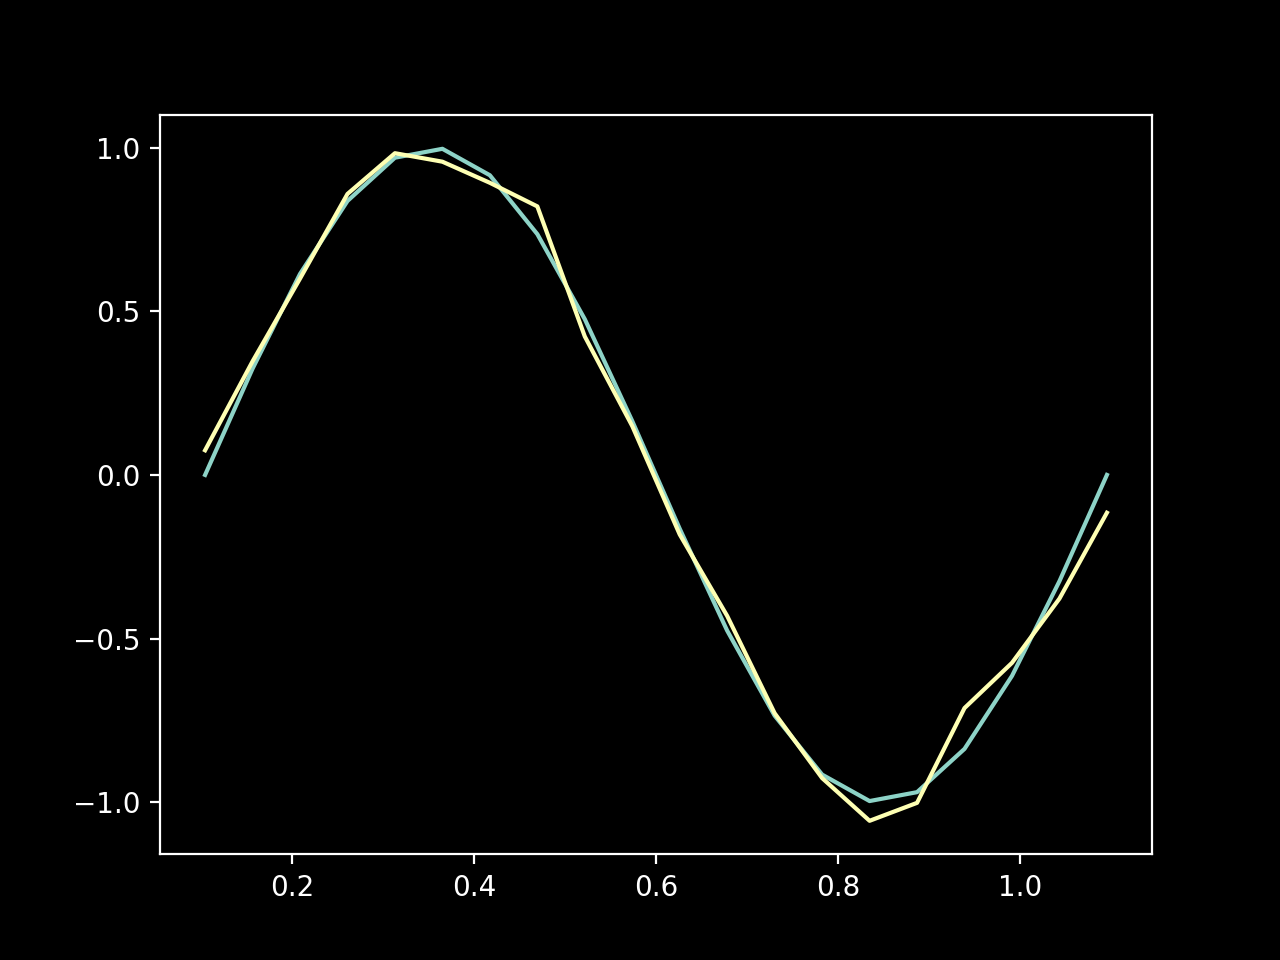

Число Куранта:
0.09999999999999999


AttributeError: 'numpy.ndarray' object has no attribute 'Transpose'

In [30]:
[x, t, PHI] = OneDimensionalTransportSchemes('RK4+center4', 1, 5, 20, 1000, 1, sin(2*pi*np.linspace(0,1,20)), zeros(1000))

fig, ax = plt.subplots()
plt.style.use('dark_background')
surf = ax.plot(x,PHI[0])
surf = ax.plot(x,PHI[200])

Error = np.zeros(5)
for i in range(1,6):
    [x, t, PHI] = OneDimensionalTransportSchemes('Euler+left', 1, 5, 20, 1000, 1, sin(2*pi*np.linspace(0,1,20*i)), zeros(1000))
    f = abs(PHI[0]-PHI[200])
    Error[i-1] = f@f.Transpose